In [1]:
from torch_geometric.data import Data
import torch
import numpy as np
from collections import Counter
from itertools import combinations
from torch.utils.data import Dataset
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from collections import defaultdict

In [2]:
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses_level.h5',key='df')
val_diagnoses = pd.read_hdf(f'{hdf}val/diagnoses_level.h5',key='df')
test_diagnoses = pd.read_hdf(f'{hdf}test/diagnoses_level.h5',key='df')

print("the size of train diagnoses is: ", train_diagnoses.shape)
print("the size of val diagnoses is: ", val_diagnoses.shape)
print("the size of test diagnoses is: ", test_diagnoses.shape)

the size of train diagnoses is:  (17336, 3)
the size of val diagnoses is:  (3754, 3)
the size of test diagnoses is:  (3326, 3)


In [3]:
train_diagnoses

,diagnosisstring,first,second
patient,,,
260132,Endocrine (R)/Hypothyroidism,Endocrine (R),Hypothyroidism
261021,Cardiovascular (R)/Pacemaker,Cardiovascular (R),Pacemaker
261021,Pulmonary/Asthma,Pulmonary,Asthma
261021,Pulmonary/COPD,Pulmonary,COPD
261021,Pulmonary/Asthma,Pulmonary,Asthma
...,...,...,...
3247116,Pulmonary/Respiratory Failure,Pulmonary,Respiratory Failure
3247116,Cardiovascular (R)/Hypertension Requiring Tre...,Cardiovascular (R),Hypertension Requiring Treatment
3247116,Pulmonary/Home Oxygen,Pulmonary,Home Oxygen


In [4]:
def build_graph(df):

    patient_graphs = []

    for pid, grp in df.groupby('patient'):
        # 1) collect all Level-1 roots
        roots = grp['first'].unique().tolist()

        # 2) collect all Level-2 leaves and their parents then combine them via '|'
        leaves = (grp['first'] + '|' + grp['second']).unique().tolist()

        # 3) put roots and leaves together
        nodes = roots + leaves
        node2idx = {node: i for i, node in enumerate(nodes)}

        # 4) build a node feature matrix
        x = torch.eye(len(nodes), dtype=torch.float)

        # 5) build edges
        edge_list = []
        #   5.1 from leaves to roots
        for leaf in leaves:
            root = leaf.split('|', 1)[0]
            u = node2idx[root]
            v = node2idx[leaf]
            # undirected edges
            edge_list.append([u, v])
            edge_list.append([v, u])

        #   5.2 from roots to roots
        for r1, r2 in combinations(roots, 2):
            u = node2idx[r1]
            v = node2idx[r2]
            edge_list.append([u, v])
            edge_list.append([v, u])
            
        #   5.3 from leaves to leaves
        root_to_leaves = defaultdict(list)
        for leaf in leaves:
            root = leaf.split('|', 1)[0]
            root_to_leaves[root].append(leaf)   ## collect leaves under the same root, e.g  {'A': ['leaf1', 'leaf2'], 'B': ['leaf3']})
        for same_root_leaves in root_to_leaves.values():
            # if there are multiple leaves under the same root, connect them to each other
            if len(same_root_leaves) > 1:
                for l1, l2 in combinations(same_root_leaves, 2):
                    u = node2idx[l1]
                    v = node2idx[l2]
                    edge_list += [[u, v], [v, u]]
        ## edge index shape [2, num_edges]
        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.zeros((2, 0), dtype=torch.long)

        # 6) build into PyG Data object
        data = Data(x=x, edge_index=edge_index)
        data.patient_id = int(pid)
        data.node_names = nodes
        # keep mask to indicate which nodes are leaves or roots
        data.mask = torch.zeros(len(nodes), dtype=torch.bool)
        for leaf in leaves:
            data.mask[node2idx[leaf]] = True
        for root in roots:
            data.mask[node2idx[root]] = True

        patient_graphs.append(data)

    print(f"Built {len(patient_graphs)} patient-tree graphs")
    return patient_graphs

In [5]:
train_graph = build_graph(train_diagnoses)
val_graph = build_graph(val_diagnoses)
test_graph = build_graph(test_diagnoses)

Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [6]:
def visualize_patient_graph(data, node_names,k, figsize=(10,10)):
    """
    draw a patient graph

    Args:
      data:        PyG Data object
      node_names:  list[str],length == data.x.size(0)
      figsize:     figure size
    """
    # 1) PyG -> NetworkX, undirected graph
    G = to_networkx(data, to_undirected=True)

    # 2) layout
    pos = nx.spring_layout(G, k=k,seed=123)

    # 3) get number of nodes
    num_nodes = data.num_nodes if isinstance(data.num_nodes, int) else data.x.size(0)

    # 4) if data has mask, use it to determine node colors
    if hasattr(data, 'mask'):
        mask = data.mask.cpu().numpy().astype(bool)
    else:
        mask = np.ones(num_nodes, dtype=bool)

    node_colors = ['lightblue' if mask[i] else 'lightgray' for i in range(num_nodes)]

    plt.figure(figsize=figsize)
    # 5) draw nodes
    nx.draw_networkx_nodes(G, pos,
                           node_color=node_colors,
                           node_size=300,
                           edgecolors='k',
                           linewidths=0.5)
    # 6) draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.6, width=1.0)
    # 7) draw labels
    nx.draw_networkx_labels(G, pos,
                            labels={i: node_names[i] for i in range(num_nodes)},
                            font_size=8)

    plt.title(f"Patient {getattr(data, 'patient_id', '')} Diagnosis Graph", fontsize=14)
    plt.axis('off')
    plt.show()


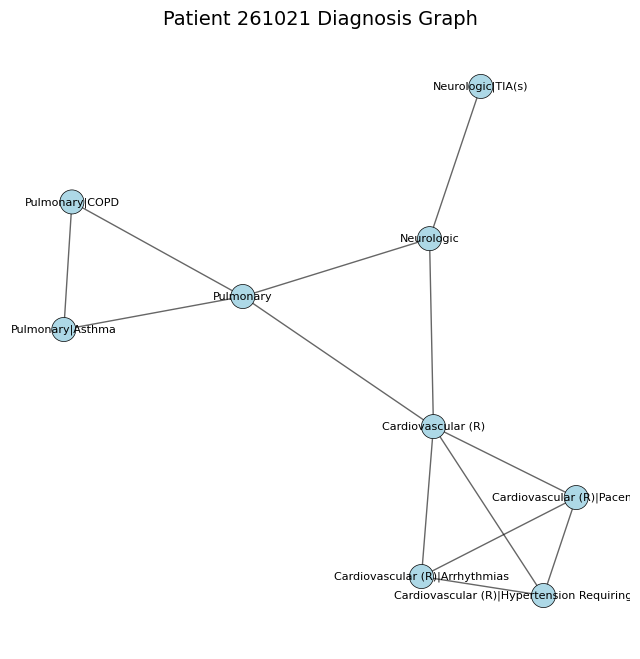

In [10]:
example = train_graph [1]
visualize_patient_graph(example, example.node_names,k=1,figsize=(8, 8))

In [11]:
patient_id = 261021
patient_info = train_diagnoses.loc[patient_id]
patient_info

,diagnosisstring,first,second
patient,,,
261021,Cardiovascular (R)/Pacemaker,Cardiovascular (R),Pacemaker
261021,Pulmonary/Asthma,Pulmonary,Asthma
261021,Pulmonary/COPD,Pulmonary,COPD
261021,Pulmonary/Asthma,Pulmonary,Asthma
261021,Cardiovascular (R)/Hypertension Requiring Tre...,Cardiovascular (R),Hypertension Requiring Treatment
261021,Cardiovascular (R)/Hypertension Requiring Tre...,Cardiovascular (R),Hypertension Requiring Treatment
261021,Neurologic/TIA(s),Neurologic,TIA(s)
261021,Pulmonary/Asthma,Pulmonary,Asthma
261021,Pulmonary/Asthma,Pulmonary,Asthma
